## Data loading

To work with any kind of data we first have to load it. For this we use a dataloader that reads the images as well as their labels and transforms them into pytorch readable tensors.

In [5]:
import pathlib

import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image

In [6]:
class RSiMCCDataset(Dataset):
    def __init__(self, transform=None):
        super().__init__()
        self.transform = transform
        # get images
        image_files = [x.resolve() for x in pathlib.Path(".").glob('data/*/*')]
        # Image.open() has a bug, this is a workaround
        self.images=[read_image(str(p)) for p in image_files] 
        # get labels from image path
        labels = [x.parts[-2] for x in image_files]
        self.classes = sorted(list(set(labels)))
        self.labels = [self.label_to_tensor(lbl) for lbl in labels]

        assert len(self.labels) == len(self.images), f"Found {len(self.labels)} labels and {len(self.images)} images"

    def label_to_tensor(self, lbl):
        """
        Converts the string label to a one-hot tensor where every entry is zero except the label which is one.
        
        """
        assert lbl in self.classes, f"Class {lbl} not a valid class (valid classes: {self.classes})"
        t = torch.zeros(len(self.classes))
        t[self.classes.index(lbl)] = 1
        return t

    def tensor_to_label(self, t):
        """
        Returns the classname in string format
        """
        assert len(t.shape) == 1, f"Can only convert 1-dimensional tensors (shape of tensor: {t.shape})"
        assert len(t) == len(self.classes), f"Lenght of tensor ({len(t)}) does not match number of classes ({len(self.classes)})"
        return self.classes[t.argmax()]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx].float()/255
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

## Examples
Now lets load the dataset and look at some examples by just randomly loading the images and their labels

In [7]:
dataset = RSiMCCDataset()

In [8]:
print(f"The dataset consists of {len(dataset)} RGB images of shape {dataset.images[0].shape} labeled in {dataset.labels[0].shape[0]} classes which are " + ', '.join(dataset.classes))

The dataset consists of 11519 RGB images of shape torch.Size([3, 64, 64]) labeled in 10 classes which are AnnualCrop, Forest, HerbaceousVegetation, Highway, Industrial, Pasture, PermanentCrop, Residential, River, SeaLake


In [46]:
dataset.images[0]

tensor([[[ 48,  47,  48,  ..., 146, 145, 151],
         [ 48,  48,  48,  ..., 146, 147, 150],
         [ 47,  48,  46,  ..., 150, 150, 151],
         ...,
         [ 51,  50,  52,  ...,  69,  83,  76],
         [ 52,  51,  49,  ...,  91,  94,  92],
         [ 50,  51,  54,  ..., 112,  99,  78]],

        [[ 75,  74,  75,  ..., 130, 128, 128],
         [ 75,  75,  74,  ..., 130, 128, 129],
         [ 76,  74,  72,  ..., 131, 129, 128],
         ...,
         [ 76,  77,  79,  ...,  84,  95,  87],
         [ 77,  78,  75,  ..., 104, 105, 100],
         [ 75,  75,  78,  ..., 124, 110,  89]],

        [[ 96,  95,  96,  ..., 133, 134, 136],
         [ 96,  96,  97,  ..., 133, 134, 136],
         [ 94,  97,  97,  ..., 135, 134, 136],
         ...,
         [ 96,  98, 100,  ..., 105, 117, 109],
         [ 97,  99,  98,  ..., 121, 125, 123],
         [ 95,  99, 102,  ..., 140, 128, 111]]], dtype=torch.uint8)

# Create my custom convolution model for the task

In [26]:
class DeepCNN(nn.Module):
    def __init__(self, nb_classes):
        super(DeepCNN, self).__init__()
        # inputs (N,3,64,64)

        # Classical processing of images with pattern recognition
        # Follows ResNET architecture: Conv2d -> BN -> ReLU (-> MaxPool)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=8)
        self.bn1   = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        # no pooling in 1st step

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding=2)
        self.bn2   = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=5)
        self.bn3   = nn.BatchNorm2d(32)
        self.relu3 = nn.ReLU()
        # no pooling in 3rd step

        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=2)
        self.bn4   = nn.BatchNorm2d(32)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=5)
        self.bn5   = nn.BatchNorm2d(16)
        self.relu5 = nn.ReLU()
        # no pooling in 5th step

        self.conv6 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, padding=2)
        self.bn6   = nn.BatchNorm2d(16)
        self.relu6 = nn.ReLU()
        self.pool6 = nn.MaxPool2d(kernel_size=2, stride=2)
        

        self.drop7 = nn.Dropout(p=0.05)
        self.lin7  = nn.Linear(16*4*4, nb_classes) # adapt here!
        
    def forward(self, x):        

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = x + self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)

        x = x + self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.pool4(x)

        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu5(x)

        x = x + self.conv6(x)
        x = self.bn6(x)
        x = self.relu6(x)
        x = self.pool6(x)

        # outputs (None, 8, 4, 4)
        x = self.drop7(x)
        x = self.lin7(x.view(-1, 16*4*4))  # adapt here!
        return x

In [27]:
def get_model(nb_classes):
    return DeepCNN(nb_classes)

In [28]:
model = get_model(len(dataset.classes))
dummy_img = torch.rand(42, 3, 64, 64)
model(dummy_img).shape

torch.Size([42, 10])

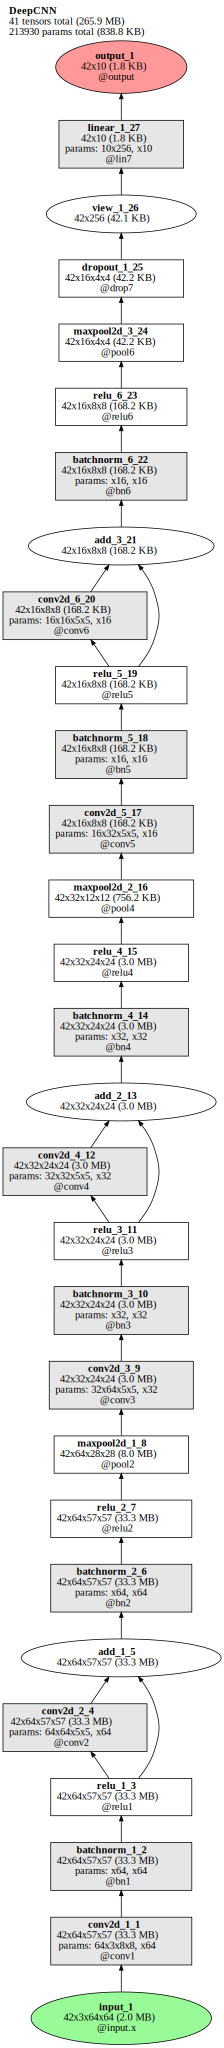

Log of DeepCNN forward pass:
	Random seed: 147172562
	Time elapsed: 7.389s (7.126s spent logging)
	Structure:
		- purely feedforward, no recurrence
		- with branching
		- no conditional (if-then) branching
		- contains 12 buffer layers
		- 23 total modules
	Tensor info:
		- 41 total tensors (265.9 MB) computed in forward pass.
		- 41 tensors (265.9 MB) with saved activations.
	Parameters: 13 parameter operations (213930 params total; 838.8 KB)
	Module Hierarchy:
		conv1
		bn1
		relu1
		conv2
		bn2
		relu2
		pool2
		conv3
		bn3
		relu3
		conv4
		bn4
		relu4
		pool4
		conv5
		bn5
		relu5
		conv6
		bn6
		relu6
		pool6
		drop7
		lin7
	Layers (all have saved activations):
		  (0) input_1 
		  (1) conv2d_1_1 
		  (2) buffer_1 
		  (3) buffer_2 
		  (4) batchnorm_1_2 
		  (5) relu_1_3 
		  (6) conv2d_2_4 
		  (7) add_1_5 
		  (8) buffer_3 
		  (9) buffer_4 
		  (10) batchnorm_2_6 
		  (11) relu_2_7 
		  (12) maxpool2d_1_8 
		  (13) conv2d_3_9 
		  (14) buffer_5 
		  (15) buffer_6 
		  (16) ba

In [29]:
import torchlens as tl
model_history = tl.log_forward_pass(model, dummy_img, layers_to_save='all', vis_opt='rolled')
print(model_history)

### Initialize the model and dataloader

In [30]:
""" from sklearn.model_selection import train_test_split

# Split dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create data loaders for training and validation sets
train_dataset = MyDataset(X_train, y_train)
val_dataset = MyDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) """

' from sklearn.model_selection import train_test_split\n\n# Split dataset into training and validation sets\nX_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)\n\n# Create data loaders for training and validation sets\ntrain_dataset = MyDataset(X_train, y_train)\nval_dataset = MyDataset(X_val, y_val)\ntrain_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)\nval_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) '

In [39]:
# Create training and validation datasets
from torch.utils.data import random_split

batch_size = 128
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

data_loader = DataLoader(dataset, batch_size=50, shuffle=True)

train_features, train_labels = next(iter(data_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")


num_classes = len(dataset.classes)
model = get_model(num_classes) # define the model
# model.load_state_dict(torch.load("best_model.pt"))


criterion = torch.nn.CrossEntropyLoss() # CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


image = torch.randn(20, 3, 64, 64) # create dummy image
output = model(image)

print(model(image).shape) # show the output of one batch of images

from torchinfo import summary
summary(model) # display summary of the model and number of trainable parameters

Feature batch shape: torch.Size([50, 3, 64, 64])
Labels batch shape: torch.Size([50, 10])
torch.Size([20, 10])


Layer (type:depth-idx)                   Param #
DeepCNN                                  --
├─Conv2d: 1-1                            12,352
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─Conv2d: 1-4                            102,464
├─BatchNorm2d: 1-5                       128
├─ReLU: 1-6                              --
├─MaxPool2d: 1-7                         --
├─Conv2d: 1-8                            51,232
├─BatchNorm2d: 1-9                       64
├─ReLU: 1-10                             --
├─Conv2d: 1-11                           25,632
├─BatchNorm2d: 1-12                      64
├─ReLU: 1-13                             --
├─MaxPool2d: 1-14                        --
├─Conv2d: 1-15                           12,816
├─BatchNorm2d: 1-16                      32
├─ReLU: 1-17                             --
├─Conv2d: 1-18                           6,416
├─BatchNorm2d: 1-19                      32
├─ReLU: 1-20                             --
├

### Send the model to the GPU

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DeepCNN(
  (conv1): Conv2d(3, 64, kernel_size=(8, 8), stride=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (conv4): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(32, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affin

### Define the training function

In [41]:
def train(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    best_val_acc = 0.0
    for epoch in range(num_epochs):
        # Training
        running_loss = 0.0
        correct = 0
        total = 0
        for batch, (X, y) in enumerate(train_loader):
            # Move tensors to the configured device
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()

            # Compute prediction and loss
            pred = model(X)

            # Compute loss and its gradients
            loss = loss_fn(pred, y)
            loss.backward()
            

            # Backpropagation step
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(pred.data, 1)
            total += y.size(0)
            correct += (predicted == y.argmax(1)).sum().item()

            # Display progress
            if batch % 5 == 0:
                loss, current = loss.item(), batch * len(X)
                print(f"Epoch {epoch+1}, batch {batch+1}/{len(train_loader)}, loss: {loss:.4f}")
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        print(f"Epoch {epoch+1}, train loss: {train_loss:.4f}, train accuracy: {train_acc:.2f}%")

        # Validation

        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch, (X, y) in enumerate(val_loader):
                X, y = X.to(device), y.to(device)
                pred = model(X)
                loss = loss_fn(pred, y)
                running_loss += loss.item()
                _, predicted = torch.max(pred.data, 1)
                total += y.size(0)
                correct += (predicted == y.argmax(1)).sum().item()
            val_loss = running_loss / len(val_loader)
            val_acc = 100 * correct / total
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            print(f"Epoch {epoch+1}, val loss: {val_loss:.4f}, val accuracy: {val_acc:.2f}%")
        
            # # Save best model
            # if val_acc > best_val_acc:
            #     best_val_acc = val_acc
            #     torch.save(model.state_dict(), "best_model.pt")

    return train_losses, train_accs, val_losses, val_accs



In [42]:
train_losses, train_accs, val_losses, val_accs = train(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=150)

Epoch 1, batch 1/72, loss: 2.6216
Epoch 1, batch 6/72, loss: 2.0553
Epoch 1, batch 11/72, loss: 2.0569
Epoch 1, batch 16/72, loss: 1.8719
Epoch 1, batch 21/72, loss: 1.7563
Epoch 1, batch 26/72, loss: 1.6705
Epoch 1, batch 31/72, loss: 1.5646
Epoch 1, batch 36/72, loss: 1.5316
Epoch 1, batch 41/72, loss: 1.4335
Epoch 1, batch 46/72, loss: 1.3437
Epoch 1, batch 51/72, loss: 1.4611
Epoch 1, batch 56/72, loss: 1.4378
Epoch 1, batch 61/72, loss: 1.3372
Epoch 1, batch 66/72, loss: 1.3022
Epoch 1, batch 71/72, loss: 1.3021
Epoch 1, train loss: 1.6205, train accuracy: 45.07%
Epoch 1, val loss: 1.1851, val accuracy: 61.28%
Epoch 2, batch 1/72, loss: 1.1426
Epoch 2, batch 6/72, loss: 1.0588
Epoch 2, batch 11/72, loss: 1.1969
Epoch 2, batch 16/72, loss: 1.0425
Epoch 2, batch 21/72, loss: 1.1251
Epoch 2, batch 26/72, loss: 1.0377
Epoch 2, batch 31/72, loss: 0.9624
Epoch 2, batch 36/72, loss: 1.0313
Epoch 2, batch 41/72, loss: 0.9759
Epoch 2, batch 46/72, loss: 0.8843
Epoch 2, batch 51/72, loss: 0

In [47]:
torch.save(model.state_dict(), "best_model_v5.pt")

In [44]:
import matplotlib.pyplot as plt

def plot_loss_accuracy2(train_losses, val_losses, train_accs, val_accs):
    # Create figure and axes
    fig, ax1 = plt.subplots(figsize=(8, 4))
    ax2 = ax1.twinx()

    # Plot loss curves
    ax1.plot(train_losses, label="Training Loss", color="blue")
    ax1.plot(val_losses, label="Validation Loss", color="orange")

    
    

    # Plot accuracy curves
    ax2.plot(train_accs, label="Training Accuracy", color="green")
    ax2.plot(val_accs, label="Validation Accuracy", color="red")
    
    
    ax1.grid()
    ax2.grid()

    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper left")
    ax1.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy (%)")
    ax2.legend(loc="upper right")
    
    plt.show()

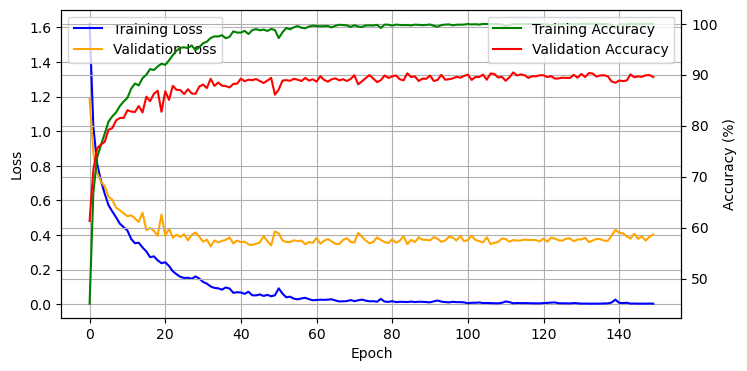

In [45]:
plot_loss_accuracy2(train_losses, val_losses, train_accs, val_accs)